In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 1) VAE Model
# -----------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=20):
      # z_dim = Latent space
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim) # mean
        self.fc_logvar = nn.Linear(hidden_dim, z_dim) # log(var)

        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)          # eps ~ N(0,1)
        return mu + std * eps  # z

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))    # MNIST in [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x) # 1) encoder
        z = self.reparameterize(mu, logvar) # 2) z >>>> latent space
        recon = self.decode(z) # 3) decoder output
        return recon, mu, logvar


def vae_loss(recon, x, mu, logvar):
    # Recon (BCE) - common for MNIST
    recon_loss = F.binary_cross_entropy(recon, x, reduction="sum")
    # KL divergence to N(0,1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Slide 3
    return recon_loss + kl, recon_loss, kl
  # return loss , recon_loss , kl


In [ ]:
class new:
  def __init__(self):
    self.a = 10
  def __call__(self, x):
    return x+self.a
new = new()
new(5)

15

In [ ]:

# -----------------------------
# 2) Data
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
# image tensor , lable

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Epoch 1: loss=164.2952 | recon=148.9177 | kl=15.3775
Epoch 2: loss=121.2209 | recon=99.1304 | kl=22.0905
Epoch 3: loss=114.2956 | recon=90.4714 | kl=23.8242


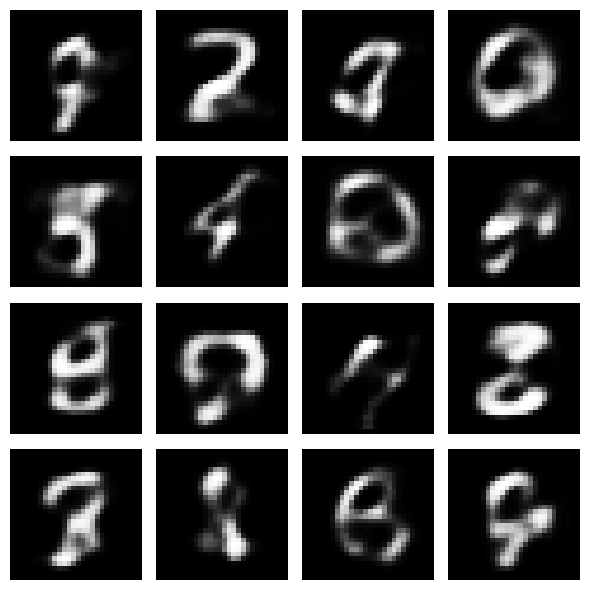

In [ ]:
# -----------------------------
# 3) Train
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"  # cuda / cpu
vae = VAE(z_dim=20).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 3  # كبداية سريعة
vae.train()

for epoch in range(1, epochs + 1):
    total_loss = 0.0 #  total_loss = total_recon + total_kl
    total_recon = 0.0
    total_kl = 0.0

    for x, _ in train_loader:
        x = x.to(device)
        x = x.view(x.size(0), -1)  # flatten: 28*28 >> (B,784)

        # 1. Forward Pass: Compute predicted outputs by passing inputs to the model
        # Note: Calling 'vae(x)' invokes the __call__ method, which runs the forward() function.
        # vae.forword(x)
        recon, mu, logvar = vae(x)

        # 2. Loss Calculation: Evaluate how well the model performed
        # We calculate both (Reconstruction loss (BCE) + Regularization loss (KL Divergence).)
        loss, recon_l, kl = vae_loss(recon, x, mu, logvar)
        # loss = Reconstruction loss + KL Divergence
        # 3. Backward Pass: Zero out gradients and compute the gradient of the loss
        # Clear existing gradients from the previous iteration to prevent accumulation.
        opt.zero_grad()

        # Compute gradients of the loss with respect to all model parameters (Backpropagation).
        loss.backward()

        # 4. Parameter Update: Adjust model weights
        # Use the optimizer (Adam) to update the weights based on the computed gradients and learning rate.
        opt.step()

        total_loss += loss.item()
        total_recon += recon_l.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_ds)
    avg_recon = total_recon / len(train_ds)
    avg_kl = total_kl / len(train_ds)
    print(f"Epoch {epoch}: loss={avg_loss:.4f} | recon={avg_recon:.4f} | kl={avg_kl:.4f}")


# -----------------------------
# 4) Generate NEW samples: z ~ N(0,1) -> decoder
# -----------------------------
vae.eval()
with torch.inference_mode():
    n = 16
    z = torch.randn(n, 20, device=device)       # sample from N(0,1)
    samples = vae.decode(z).view(n, 1, 28, 28)  # back to image shape

# Plot grid 4x4
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
